## Frequency estimation from a seismic image

This is all from [Endolith's frequency estimator code](https://gist.github.com/endolith/255291)

In [2]:
from numpy.fft import rfft
from numpy import argmax, mean, diff, log
from matplotlib.mlab import find
from scipy.signal import blackmanharris, fftconvolve
import scipy.stats
 
from parabolic import parabolic

A test image [from Berkeley](https://math.berkeley.edu/~sethian/2006/Applications/Seismic/elf-fmg2.jpg)... The image is 2000 ms tall and 12 km across.

<img src="https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_2000ms_12000m.png" width="240px" />

Here is [another](https://math.berkeley.edu/~sethian/2006/Applications/Seismic/smooth_elf_post_img.jpg) and [another](https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg).

### Read an image

In [3]:
from scipy import misc, ndimage

In [4]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
#url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_2000ms_12000m.png"
url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_3000ms_8000m.png"
r = requests.get(url)
im = Image.open(BytesIO(r.content))

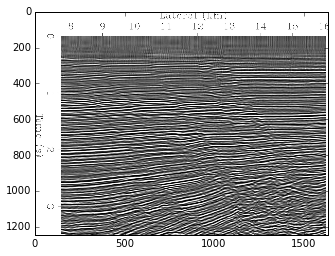

In [6]:
plt.imshow(im)
plt.show()

In [154]:
i = np.asarray(im, dtype=int)
i.shape

(692, 664, 3)

We need the sampling frequency.

In [155]:
fs = len(t) / 2.000
fs

468.0

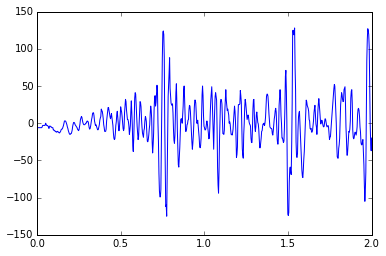

In [156]:
t = np.linspace(0, 2.000, i.shape[0])

a = i[:,100,0] - 127
plt.plot(t, a)
plt.show()

In [239]:
from PIL import ImageStat
s = ImageStat.Stat(im)
print(s.sum)
sum(s.sum[:3])/3 == s.sum[0]

[130210903.0, 130210903.0, 130210903.0, 332242560.0]


True

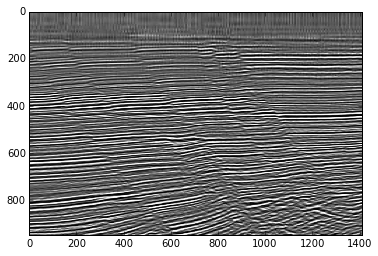

In [9]:
url = "https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg"
r = requests.get(url)
im = Image.open(BytesIO(r.content))

region = '199,141,1608,1087'
r = [int(n) for n in region.split(',')]
i = im.crop(r)
plt.imshow(i)

##Image segmentation from Yoink

In [37]:
from scipy import ndimage
from skimage import img_as_uint
from skimage.measure import approximate_polygon
from skimage.feature import corner_harris

def guess_corners(bw):
    """
    Infer the corners of an image using a Sobel filter to find the edges and a
    Harris filter to find the corners.  Takes a single color chanel.
    Parameters
    ----------
    bw : (m x n) ndarray of ints
    Returns
    -------
    corners : pixel coordinates of plot corners, unsorted
    outline : (m x n) ndarray of bools True -> plot area
    """
    assert len(bw.shape) == 2
    bw = img_as_uint(bw)
    e_map = ndimage.sobel(bw)

    markers = np.zeros(bw.shape, dtype=int)
    markers[bw < 20] = 1
    markers[bw > 200] = 2
    seg = ndimage.watershed_ift(e_map, np.asarray(markers, dtype=int))
    plt.imshow(markers)

    outline = ndimage.binary_fill_holes(1 - seg)
    corners = corner_harris(np.asarray(outline))
    print(corners.shape)
    corners = approximate_polygon(corners, 1)
    return corners, outline


(1245, 1636)


ValueError: too many values to unpack (expected 2)

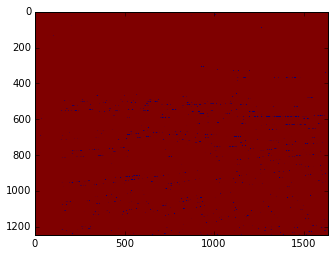

In [38]:
j = np.asarray(im)[...,0]
guess_corners(j)

##Frequency estimation

###Count zero-crossings, divide average period by time to get frequency

* Works well for long low-noise sines, square, triangle, etc.
* Supposedly this is how cheap guitar tuners work
* Using interpolation to find a "truer" zero-crossing gives better accuracy
* Pro: Fast
* Pro: Accurate (increasing with signal length)
* Con: Doesn't work if there are multiple zero crossings per cycle, low-frequency baseline shift, noise, etc.



In [157]:
def freq_from_crossings(sig, fs):
    """
    Estimate frequency by counting zero crossings
    
    """
    # Find all indices right before a rising-edge zero crossing
    indices = find((sig[1:] >= 0) & (sig[:-1] < 0))
    
    # Naive (Measures 1000.185 Hz for 1000 Hz, for instance)
    #crossings = indices
    
    # More accurate, using linear interpolation to find intersample 
    # zero-crossings (Measures 1000.000129 Hz for 1000 Hz, for instance)
    crossings = [i - sig[i] / (sig[i+1] - sig[i]) for i in indices]
    
    # Some other interpolation based on neighboring points might be better. Spline, cubic, whatever
    
    return fs / np.mean(np.diff(crossings))

In [230]:
a, b = 2.3, 4.5

In [158]:
freq_from_crossings(a, fs)

35.354459067233911

### Do FFT and find the peak

* Using parabolic interpolation to find a truer peak gives better accuracy
* Accuracy also increases with signal/FFT length
* Con: Doesn't find the right value if harmonics are stronger than fundamental, which is common.  Better method would try to be smarter about identifying the fundamental, like template matching using the ["two-way mismatch" (TWM) algorithm](http://ems.music.uiuc.edu/beaucham/papers/JASA.04.94.pdf).
* Pro: Accurate, usually even more so than zero crossing counter (1000.000004 Hz for 1000 Hz, for instance).  Due to [parabolic interpolation being a very good fit](https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html) for windowed log FFT peaks?

In [159]:
def freq_from_fft(signal, fs):
    """
    Estimate frequency from peak of FFT
    
    """
    # Compute Fourier transform of windowed signal
    windowed = signal * blackmanharris(len(signal))
    f = rfft(windowed)
    
    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f)) # Just use this for less-accurate, naive version
    true_i = parabolic(log(abs(f)), i)[0]
    
    # Convert to equivalent frequency
    return fs * true_i / len(windowed)

In [160]:
freq_from_fft(a, fs)

35.019436161856909

### Do autocorrelation and find the peak

* Pro: Best method for finding the true fundamental of any repetitive wave, even with weak or missing fundamental (finds GCD of all harmonics present)
* Con: Inaccurate result if waveform isn't perfectly repeating, like inharmonic musical instruments (piano, guitar, ...), however:
 * Pro: This inaccurate result more closely matches the pitch that humans perceive :)
* Con: Not as accurate as other methods for precise measurement of sine waves
* Con: This implementation has trouble with finding the true peak

In [161]:
def freq_from_autocorr(sig, fs):
    """
    Estimate frequency using autocorrelation
    
    """
    # Seems to only work if all positive
    sig = sig + 127
    
    # Calculate autocorrelation (same thing as convolution, but with 
    # one input reversed in time), and throw away the negative lags
    corr = fftconvolve(sig, sig[::-1], mode='full')
    corr = corr[len(corr)/2:]
    
    # Find the first low point
    d = diff(corr)
    start = find(d > 0)[0]
    
    # Find the next peak after the low point (other than 0 lag).  This bit is 
    # not reliable for long signals, due to the desired peak occurring between 
    # samples, and other peaks appearing higher.
    # Should use a weighting function to de-emphasize the peaks at longer lags.
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)
    
    return fs / px

In [162]:
freq_from_autocorr(a, fs)

33.583204417651366

### Calculate harmonic product spectrum and find the peak

* Pro: Good at finding the true fundamental even if weak or missing

In [163]:
def freq_from_HPS(signal, fs):
    """
    Estimate frequency using harmonic product spectrum (HPS)
    
    """
    windowed = signal * blackmanharris(len(signal))
 
    from pylab import subplot, plot, log, copy, show
 
    # Harmonic product spectrum:
    c = abs(rfft(windowed))
    maxharms = 8
    subplot(maxharms, 1, 1)
    plot(log(c))
    for x in range(2, maxharms):
        a = copy(c[::x]) #Should average or maximum instead of decimating
        # max(c[::x],c[1::x],c[2::x],...)
        c = c[:len(a)]
        i = argmax(abs(c))
        
        try:
            true_i = parabolic(abs(c), i)[0]
        except IndexError as e:
            break

        print('Pass %d: %f Hz' % (x, fs * true_i / len(windowed)))
        c *= a
        subplot(maxharms,1,x)
        plot(log(c))
    show()

Pass 2: 35.033627 Hz
Pass 3: 16.367290 Hz
Pass 4: 8.417056 Hz
Pass 5: -0.010089 Hz


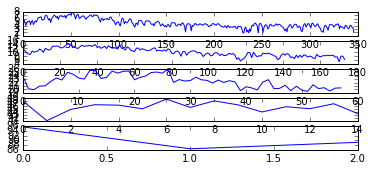

In [164]:
freq_from_HPS(a, fs)

## Do ten and average

In [165]:
def get_freq(im, t_min, t_max, func):
    
    # Cast as array and centre on 0
    i = np.asarray(im, dtype=int) - 127
       
    # Calculate a timebase
    #t = np.linspace(t_min, t_max, i.shape[0])

    # Calculate the sampling frequency
    fs = i.shape[0] / (t_max - t_min)
    
    # Get the slices we want
    slices = np.arange(1/11,1,1/11) * i.shape[1]
    
    results = []
    for s in slices:
        a = i[:, s, 0]  # The RGB channels are all the same
        
        try:
            f = func(a, fs)
            results.append(f)
            print(f)
        except Exception as e:
            print(e)
            continue
    
    return scipy.stats.trim_mean(results, 0.2)

In [166]:
get_freq(im, 0, 2, freq_from_crossings)

26.8758450313
28.4914071913
27.400621118
26.2919550838
20.7635493247
21.2811144697
22.9730726669
27.9335142469
31.0862418374
27.4933169834


26.494720855077123

In [167]:
get_freq(im, 0, 2, freq_from_fft)

33.9457130949
25.5949008614
35.3344842988
32.5316829094
11.5277079791
12.815794095
13.0286222272
33.7431467921
38.4877404155
26.8769838838


27.620174961454822

In [168]:
get_freq(im, 0, 2, freq_from_autocorr)

30.3677946411
28.4693123787
33.440053631
36.159006252
41.2071297072
19.0397418295
17.5509723309
34.1570736036
36.6993978694
37.5389534264


33.215439729308258

##Do all from URL

In [169]:
def image_freq(url, t_min, t_max):
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    try:
        f = get_freq(im, t_min, t_max, freq_from_crossings)
    except:
        f = get_freq(im, t_min, t_max, freq_from_autocorr)
    return f

In [171]:
url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_2000ms_12000m.png"
#url = "https://dl.dropboxusercontent.com/u/14965965/Seismic_sample_3000ms_8000m.png"

image_freq(url, 0, 2)

26.8758450313
28.4914071913
27.400621118
26.2919550838
20.7635493247
21.2811144697
22.9730726669
27.9335142469
31.0862418374
27.4933169834


26.494720855077123

##Segmentation

In [172]:
from skimage import data
coins = data.coins()
histo = np.histogram(coins, bins=np.arange(0, 256))

In [173]:
from skimage.feature import canny
edges = canny(coins/255.)

In [174]:
from scipy import ndimage
fill_coins = ndimage.binary_fill_holes(edges)

In [175]:
label_objects, nb_labels = ndimage.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]

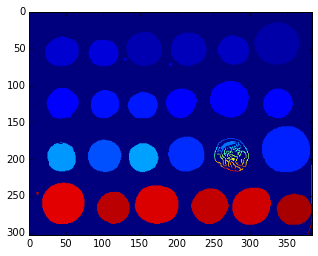

In [179]:
plt.imshow(label_objects)

In [180]:
nb_labels

113

In [192]:
from skimage.filters import sobel
elevation_map = sobel(coins)
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

from skimage.morphology import watershed
segmentation = watershed(elevation_map, markers)
segmentation = ndimage.binary_fill_holes(segmentation - 1)
labeled_coins, nb_labels = ndimage.label(segmentation)

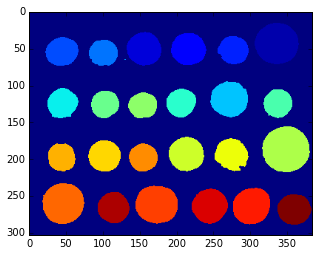

In [193]:
plt.imshow(labeled_coins)

In [196]:
from skimage import measure
props = measure.regionprops(labeled_coins)

In [195]:
measure.regionprops?

In [206]:
for p in props:
    print(p.label)
    print(p.area)
    print(p.bbox)

1
2604.0
(16, 305, 72, 365)
2
1653.0
(28, 132, 74, 179)
3
1622.0
(30, 192, 73, 240)
4
1225.0
(34, 255, 72, 297)
5
1355.0
(35, 22, 74, 67)
6
1103.0
(39, 81, 74, 120)
7
2.0
(65, 129, 66, 131)
8
1920.0
(95, 245, 144, 296)
9
1298.0
(104, 25, 145, 67)
10
1209.0
(105, 186, 144, 226)
11
1175.0
(106, 317, 145, 356)
12
1111.0
(108, 84, 145, 122)
13
1077.0
(110, 134, 145, 173)
14
3141.0
(156, 315, 218, 380)
15
1737.0
(170, 189, 217, 237)
16
1496.0
(172, 251, 217, 297)
17
1471.0
(175, 80, 217, 124)
18
1124.0
(179, 26, 217, 63)
19
1152.0
(179, 135, 217, 174)
20
2461.0
(233, 18, 288, 75)
21
2350.0
(236, 144, 288, 201)
22
1993.0
(239, 276, 289, 326)
23
1765.0
(240, 220, 288, 269)
24
1416.0
(245, 93, 287, 136)
25
1485.0
(248, 336, 289, 382)


In [ ]:
from skimage.segmentation import slic

In [219]:
url = "https://math.berkeley.edu/~sethian/2006/Applications/Seismic/time_mig_img.jpg"
r = requests.get(url)
im = Image.open(BytesIO(r.content))

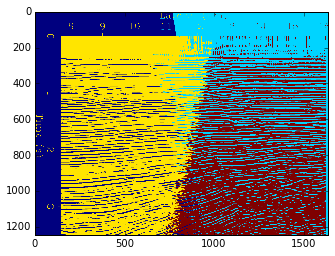

In [228]:
segments = slic(im, n_segments=4, compactness=50)
plt.imshow(segments)